In [64]:
import geopandas
import pandas as pd
import xarray as xr
from tqdm.notebook import trange, tqdm
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt
from config import get_config
config = get_config()

# Notebook exploratoire 

## Fusion des communes en bassin de vie

In [2]:
communes_geo = geopandas.read_file(config['path_communes'])
type(communes_geo)

geopandas.geodataframe.GeoDataFrame

In [3]:
communes_geo.shape
communes = pd.read_csv(config['path_BdV'], sep =';', encoding='latin1', dtype=str) 
commune_bdv = pd.merge(communes_geo, communes, left_on = 'insee', right_on = 'CODGEO', how = 'inner').drop('CODGEO', axis = 1)
print(commune_bdv.shape)
commune_bdv.head()

(34970, 10)


,insee,nom,wikipedia,surf_ha,geometry,LIBGEO,BV2012,LIBBV2012,DEP,REG
0,97223,Saint-Esprit,fr:Saint-Esprit (Martinique),2318.0,"POLYGON ((-60.95617 14.55766, -60.95561 14.557...",Saint-Esprit,97222,Le Robert,972,02
1,97233,Le Morne-Vert,fr:Le Morne-Vert,1325.0,"POLYGON ((-61.15922 14.70645, -61.15917 14.706...",Le Morne-Vert,97209,Fort-de-France,972,02
2,97208,Fonds-Saint-Denis,fr:Fonds-Saint-Denis,2374.0,"POLYGON ((-61.16254 14.74252, -61.16232 14.743...",Fonds-Saint-Denis,97209,Fort-de-France,972,02
3,97224,Saint-Joseph,fr:Saint-Joseph (Martinique),4324.0,"POLYGON ((-61.08680 14.71891, -61.08678 14.719...",Saint-Joseph,97209,Fort-de-France,972,02
4,97212,Gros-Morne,fr:Gros-Morne,4601.0,"POLYGON ((-61.08483 14.72449, -61.08481 14.724...",Gros-Morne,97222,Le Robert,972,02


In [4]:
bassin_de_vie = commune_bdv.dissolve(by='BV2012')

In [5]:
bassin_de_vie.to_file(config['path_BdV_shp'])

In [22]:
bassin_de_vie.head()

,geometry,insee,nom,wikipedia,surf_ha,LIBGEO,LIBBV2012,DEP,REG
BV2012,,,,,,,,,
01004,"POLYGON ((5.38236 45.91829, 5.38027 45.92025, ...",01384,Saint-Rambert-en-Bugey,fr:Saint-Rambert-en-Bugey,2888.0,Saint-Rambert-en-Bugey,Ambérieu-en-Bugey,01,84
01033,"POLYGON ((5.84466 46.03911, 5.84460 46.03931, ...",01033,Valserhône,fr:Valserhône,6280.0,Valserhône,Valserhône,01,84
01034,"POLYGON ((5.70411 45.69672, 5.70505 45.69512, ...",01110,Colomieu,fr:Colomieu,595.0,Colomieu,Belley,01,84
01053,"POLYGON ((5.17834 46.07590, 5.17835 46.07605, ...",01038,Bény,fr:Bény,1826.0,Bény,Bourg-en-Bresse,01,84
01093,"POLYGON ((4.85163 46.06542, 4.85170 46.06602, ...",01328,Romans,fr:Romans (Ain),2210.0,Romans,Châtillon-sur-Chalaronne,01,84


<class 'shapely.geometry.polygon.Polygon'>


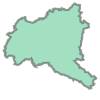

In [7]:
print(type(bassin_de_vie['geometry'][0]))
bassin_de_vie['geometry'][0]

## Concaténation de la pollution sur les bassins de vie

In [8]:
ds = xr.open_dataset(config['path_PM25'])
df = ds.to_dataframe()

In [9]:
ds.head()

<xarray.Dataset>
Dimensions:     (Times: 5, lat: 5, lon: 5, bnds: 2)
Coordinates:
  * Times       (Times) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
  * lat         (lat) float64 40.48 40.49 40.51 40.52 40.54
  * lon         (lon) float64 -5.578 -5.547 -5.516 -5.484 -5.453
Dimensions without coordinates: bnds
Data variables:
    PM25        (Times, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    Times_bnds  (Times, bnds) float64 2.019e+07 2.019e+07 ... 2.019e+07
Attributes:
    CDI:                       Climate Data Interface version 1.7.2 (http://m...
    Conventions:               CF-1.4
    Title:                     Reanalysed CHIMERE data
    Generating_process:        Generated by post-processing (kriging) of CHIM...
    Domain:                    FRA02e
    Chimere_version:           V2017
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1
    frequency:                 day
    CDO:                       Climate Data Operators version 1.7.2rc6 (http:...

<cite>
bounds = "time_bnds". "time_bnds" is a separate 2-dimensional variable that defines the start and end time points of each measurement. Variable "time_bnds" has the same attributes "units" and "calendar" as variable "time".
</cite>  

from https://daac.ornl.gov/submit/netcdfrequirements/

In [10]:
print(type(ds))
print(ds.dims)

<class 'xarray.core.dataset.Dataset'>
Frozen({'Times': 365, 'lat': 761, 'lon': 541, 'bnds': 2})


In [11]:
print('number of longitudinal values :',len(ds.variables['lon']))
print('number of lattitude values :',len(ds.variables['lat']))
print(type(ds.variables['lat']))
print(len(ds.variables['lon'])*len(ds.variables['lat']), "points on map")

number of longitudinal values : 541
number of lattitude values : 761
<class 'xarray.core.variable.IndexVariable'>
411701 points on map


In [12]:
ds.variables['PM25'].shape

(365, 761, 541)

Next step is to see if a pollution point is inside a bassin de vie or not  
Seems like PIP (Point in Polygon) is the solution ==> Ray casting algorythm  

shoots a ray : even number of hit through the polygon : outside, odd : inside  
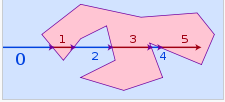

Already implemented in the shapely lib  

2 syntax : 

p2.within(poly)  

poly.contains(p1)



In [13]:
# select a poly 
# bassin_de_vie['geometry'][0]
# create a point 
from shapely.geometry import Point, Polygon

p_test = Point(ds.variables['lat'][0].to_numpy(), ds.variables['lon'][0].to_numpy())
type(p_test)

shapely.geometry.point.Point

False
False


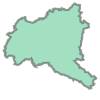

In [14]:
print(p_test.within(bassin_de_vie['geometry'][0]))
print(bassin_de_vie['geometry'][0].contains(p_test))
bassin_de_vie['geometry'][0]

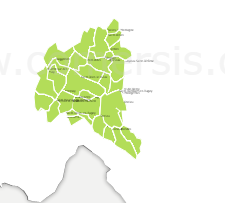

In [15]:
p_true = Point(5.443477, 45.940115)
print(p_true.within(bassin_de_vie['geometry'][0]))
print(bassin_de_vie['geometry'][0].contains(p_true))
print(bassin_de_vie['nom'][0])

True
True
Saint-Rambert-en-Bugey


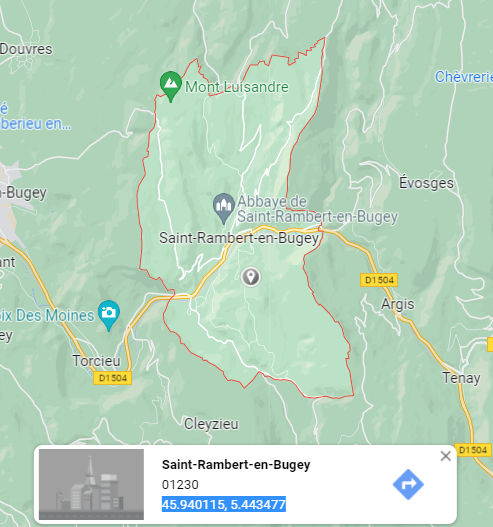  

now we can create a dataset containing pollution on a given day for a given bassin de vie  
First, we're going to try with Paris' bassin de vie : 
- plot the bassin de vie
- plot every pollution point on the map
- concatenate them 
- yearly plot 

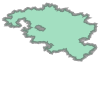

In [16]:
bassin_de_vie.loc[bassin_de_vie['LIBBV2012'] == 'Paris']['geometry'][0]

https://xarray.pydata.org/en/v0.7.1/generated/xarray.Dataset.html  
Quite useful, iter methods may be the solution

Il faut distinguer les variables des indexVariables

In [37]:
ds.variables['lon']

<xarray.IndexVariable 'lon' (lon: 541)>
array([-5.57812, -5.54687, -5.51562, ..., 11.23438, 11.26563, 11.29688])
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [18]:
list_point=[]
for lat in trange(761) : 
    for long in range(541) : 
        if (Point(ds.variables['lon'][long], ds.variables['lat'][lat]).within(bassin_de_vie.loc[bassin_de_vie['LIBBV2012'] == 'Paris']['geometry'][0])) : 
            list_point.append(Point(ds.variables['lon'][long], ds.variables['lat'][lat]))

  0%|          | 0/761 [00:00<?, ?it/s]

Complexity is BAD : 
- .apply()
- Vectorized approaches

In [19]:
print(len(list_point))

996


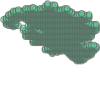

In [20]:
MultiPoint(list_point)

Low-cost way of checking that points are indeed from Paris' bassin de vie    

Maybe we should be storing indexes to access every day data like this :  

list_pol=[]  
for day in year :   
----cumul=0  
----for lon_index, lat_index in list_index :   
--------cumul+= PM25[day][lat][long]   
----list_pol.append(cumul)   

In [23]:
list_index=[]
for lat in trange(761) : 
    for long in range(541) : 
        if (Point(ds.variables['lon'][long], ds.variables['lat'][lat]).within(bassin_de_vie.loc[bassin_de_vie['LIBBV2012'] == 'Paris']['geometry'][0])) : 
            list_index.append((lat,long))

  0%|          | 0/761 [00:00<?, ?it/s]

In [68]:
print(ds.isel(lon=[0], lat=[0], Times=364)['PM25'].values[0][0])

nan


In [59]:
list_poll = []
for day in trange(365) : 
    cumul=0
    for lat,lon in list_index : 
        cumul+=ds.isel(lat=[lat],lon=[lon], Times=day)['PM25'].values[0][0]
    list_poll.append(cumul)

  0%|          | 0/365 [00:00<?, ?it/s]

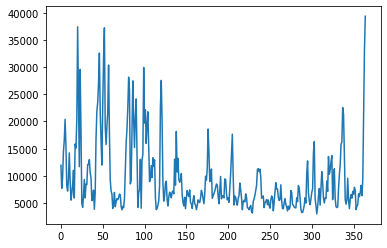

In [65]:
plt.plot(list_poll)

Evolution de la pollution à Paris en 2019